In [1]:
%load_ext autoreload
%autoreload 2

# Training

In [2]:
import time
import os
import torch
import math
import numpy as np
from torch import nn
from torch.utils.data import Dataset, sampler
from models import Encoder, Decoder
from train_utils import train, validate, early_stopping
from data import Vocabulary, get_loader
from fastprogress.fastprogress import master_bar, progress_bar
import wandb

In [3]:
#!wandb login

Remember to run `wandb login` in the terminal to authenticate, for some reason `!wandb login` doesn't work

In [4]:
# Hyperparameters
cfg = { 
        "device" : "cuda" if torch.cuda.is_available() else "cpu",
        "batch_size" : 32,
        "num_epochs" : 15,
        "lr" : 0.001,
        "momentum": 0.01,
        "hidden_size": 512,
        "embed_size": 512,
        "n_layers": 1,
        "dropout": 0.1,
        "seed" : 0,
        "dataset": "flickr8k"
        }

# Setting seeds for reproducibility
torch.manual_seed(cfg["seed"])
np.random.seed(cfg["seed"])
#torch.backends.cudnn.deterministic = True # It makes training slower

# Logs
train_losses = []
val_losses = []
val_bleus = []
best_bleu = float("-INF")

In [5]:
# Data loaders
train_loader = get_loader("TRAIN", cfg["batch_size"])
val_loader = get_loader("VAL", cfg["batch_size"])

# Models
encoder = Encoder(cfg["embed_size"], cfg["momentum"]).to(cfg["device"])
decoder = Decoder(cfg["embed_size"], 
                  cfg["hidden_size"], 
                  len(train_loader.dataset.vocab),
                  cfg["n_layers"],
                  cfg["dropout"]).to(cfg["device"])

# Loss and optimizer
criterion = nn.CrossEntropyLoss().to(cfg["device"])
params = (list(filter(lambda p: p.requires_grad, encoder.parameters()))+
        list(filter(lambda p: p.requires_grad, decoder.parameters())))
optimizer = torch.optim.Adam(params, lr=cfg["lr"])

In [6]:
# Wandb project init
wandb.init(
  project="autocaption",
  notes="baseline",
  tags=["baseline"],
  config=cfg,
)

wandb.watch([encoder, decoder])

In [7]:
mb = master_bar(range(cfg["num_epochs"]))

for epoch in mb:
    start = time.time()
    train_loss = train( loader=train_loader,
                        encoder=encoder,
                        decoder=decoder,
                        criterion=criterion,
                        opt=optimizer,
                        epoch=epoch,
                        cfg=cfg,
                        mb=mb)
    train_losses.append(train_loss)
    
    

    val_loss, val_bleu = validate(  loader=val_loader,
                                    encoder=encoder,
                                    decoder=decoder,
                                    criterion=criterion,
                                    epoch=epoch,
                                    cfg=cfg,
                                    mb=mb)
    val_losses.append(val_loss)
    val_bleus.append(val_bleu)
    
    mb.write('> Epoch {}/{}'.format(epoch + 1, cfg["num_epochs"]))
    mb.write('# TRAIN')
    mb.write('# Loss {:.3f}, Perplexity {:.3f}'.format(train_loss, np.exp(train_loss)))
    mb.write('# VALIDATION')
    mb.write('# Loss {:.3f}, Perplexity {:.3f}, BLEU {:.3f}'.format(val_loss, np.exp(val_loss), val_bleu))
    mb.write(">Runtime {:.3f}".format(time.time() - start))

    # Send logs to wandb
    wandb.log({'train_loss': train_loss,
               'train_perplexity': np.exp(train_loss),
               'val_loss': val_loss,
               'val_perplexity': np.exp(val_loss),
               'val_bleu': val_bleu}, step=epoch)
    
    if val_bleu > best_bleu:
        mb.write("Validation BLEU improved from {} to {}, saving model at ./data/models/best-model.ckpt".format(best_bleu, val_bleu))
        best_bleu = val_bleu
        
        filename = os.path.join("./data/models", "best-model.ckpt")
        torch.save({"encoder": encoder.state_dict(),
                    "decoder": decoder.state_dict(),
                    "optimizer": optimizer.state_dict(),
                    "train_losses": train_losses,
                    "val_losses": val_losses,
                    "best_bleu": best_bleu,
                    "val_bleus": val_bleus,
                    "epoch": epoch
                }, filename)
    else:
        mb.write("Validation BLEU did not improve, saving model at ./data/models/model-{}.ckpt".format(epoch))
        filename = os.path.join("./data/models", "model-{}.ckpt".format(epoch))
        torch.save({"encoder": encoder.state_dict(),
                    "decoder": decoder.state_dict(),
                    "optimizer": optimizer.state_dict(),
                    "train_losses": train_losses,
                    "val_losses": val_losses,
                    "best_bleu": best_bleu,
                    "val_bleus": val_bleus,
                    "epoch": epoch
                }, filename)
    
    # Saving last model to wandb, works only if Jupyter is executed as Admin
    try: 
        wandb.save(filename)
    except:
        pass
        
    if epoch > 2:
        if early_stopping(val_bleus, patience=3):
            mb.write("Validation BLEU did not improve for 3 consecutive epochs, stopping")
            break

# Testing

In [11]:
import os
import torch
from models import Encoder, Decoder
import matplotlib.pyplot as plt
from utils import get_caption
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

loader = get_loader("TEST", cfg["batch_size"])

model_name = 'best-model.ckpt'
checkpoint = torch.load(os.path.join('./data/models', model_name))
encoder = Encoder(cfg["embed_size"], cfg["momentum"]).to(cfg["device"])
decoder = Decoder(cfg["embed_size"], 
                  cfg["hidden_size"], 
                  len(train_loader.dataset.vocab),
                  cfg["n_layers"],
                  cfg["dropout"]).to(cfg["device"])

encoder.load_state_dict(checkpoint['encoder'])
decoder.load_state_dict(checkpoint['decoder'])

encoder.eval()
decoder.eval()

Decoder(
  (embed): Embedding(1842, 512)
  (dropout): Dropout(p=0.1, inplace=False)
  (lstm): LSTM(512, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=1842, bias=True)
)

In [53]:
results = []
results_beam = []

mb = progress_bar(loader)

with torch.no_grad():
    for (orig_image, image, all_caps) in mb:
        image = image.to(cfg["device"])
            
        # Greedy
        candidates = get_caption(image, 
                                encoder, 
                                decoder, 
                                loader.dataset.vocab,
                                "greedy",
                                True)

        candidates_bleu = [c.split() for c in candidates][0]
        all_caps = [c[0].split() for c in all_caps]
        bleu_score = sentence_bleu(all_caps, candidates_bleu, smoothing_function=SmoothingFunction().method1)
        

        # Beam
        candidates_beam = get_caption(image, 
                                encoder, 
                                decoder, 
                                loader.dataset.vocab,
                                "beam",
                                True)

        candidates_bleu = [c.split() for c in candidates_beam][0]
        bleu_score_beam = sentence_bleu(all_caps, candidates_bleu, smoothing_function=SmoothingFunction().method1)
        
        
        # Logging
        all_caps = [" ".join(c) for c in all_caps]
        
        results.append({"orig_image": orig_image, 
                        "caption": candidates[0],
                        "all_caps": all_caps,
                        "bleu": bleu_score})
                
        results_beam.append({"orig_image": orig_image, 
                        "caption": candidates_beam,
                        "all_caps": all_caps,
                        "bleu": bleu_score_beam})
        
        # Send logs to wandb
        wandb.log({'greedy_test_bleu': bleu_score,
                   'beam_test_bleu': bleu_score_beam})

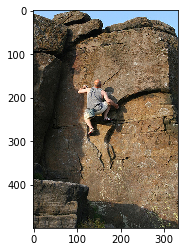

>Generated caption: 
man climbing rock wall
>Original captions: 
man dressed in grey climbing large brown rock
man in gray shirt climbs large rock wall
man in shorts climbs rock face
man climbing rock wall
the back of man climbing rock
>BLEU4 score: 1.000


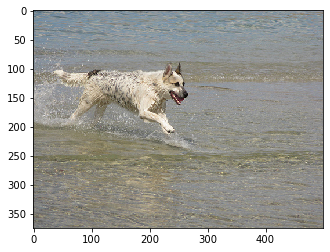

>Generated caption: 
white dog is running through the water
>Original captions: 
pale colored dog runs through body of water
white dog is running through the water at beach
white dog is running through the water onto the shore
the white dog runs through the ocean
white medium sized dog is running through the ocean
>BLEU4 score: 1.000


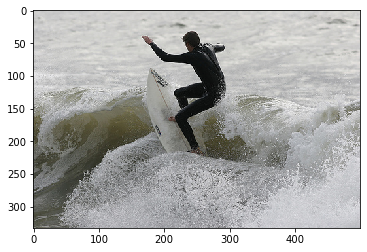

>Generated caption: 
man in wetsuit is surfing
>Original captions: 
lone surfer on white surfboard atop huge wave in the ocean
man in wetsuit is surfing up and over wave
man in wetsuit surfs
surfer in black wetsuit rides wave
this is male surfer riding against the waves
>BLEU4 score: 1.000


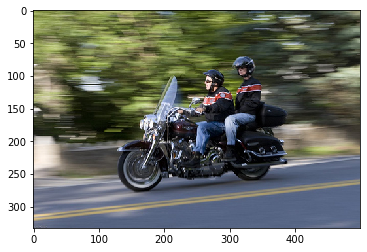

>Generated caption: 
two people on motorcycle
>Original captions: 
two motorcyclists riding tandom on biek down the street
two people are on black motorcycle driving very fast
two people on motorcycle
two people ride together on motorcycle
two people riding motorcycle
>BLEU4 score: 1.000


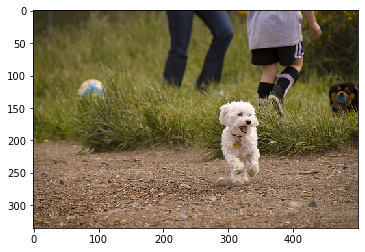

>Generated caption: 
small white dog is running through the grass
>Original captions: 
small white dog is running through the dirt right on the outside of patch of grass where two people and another small black dog are playing
small white dog runs
white dog is running on gravel away from two people and black and brown dog
white dog outside with two people in background
white fluffy dog running in the dirt
>BLEU4 score: 0.869


In [58]:
results = sorted(results, key=lambda k: k['bleu'], reverse=True) 

top = results[0:5]
worst = results[-5:]

for e in top:
    orig_image = e["orig_image"]
    caption = e["caption"]
    all_caps = e["all_caps"]
    bleu = e["bleu"]

    plt.imshow(np.squeeze(orig_image))
    #plt.title("Sampled Image")
    #plt.figtext(0.5, 0.01, caption, wrap=True, ha='center', fontsize=12)
    #plt.figtext(0.5, -0.05, "BLEU4 score: {:.2f}".format(bleu), wrap=True, ha='center', fontsize=12)
    plt.show()
    print(">Generated caption: ")
    print(caption)
    print(">Original captions: ")
    for c in all_caps:
        print(c)
    print(">BLEU4 score: {:.3f}".format(bleu))


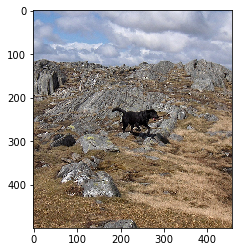

>Generated caption: 
two dogs are standing in the snow
>Original captions: 
black dog is running across rocky landscape
black dog is running gover rocky ground under cloudy blue sky
black dog walking along rocky terrain
black dog walks through rocky grassy landscape under blue cloudy sky
dog on rocky terrain
>BLEU4 score: 0.000


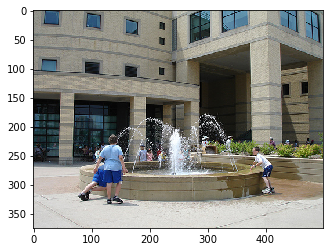

>Generated caption: 
man is sitting on bench with his feet on the sidewalk
>Original captions: 
few younger boys play around fountain
group of people gather around large fountain
three boys play around fountain in an office building courtyard
three kids are playing at fountain in front of building
three kids playing around fountain
>BLEU4 score: 0.000


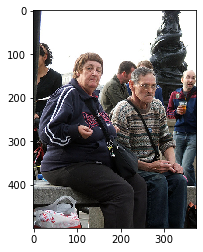

>Generated caption: 
two men in matching suits are standing in front of <unk>
>Original captions: 
man and woman sitting on bench
an older couple is resting on bench
an older man and woman sitting on cement bench with frowns on their faces
an older woman and an old man sitting down looking unhappy
an overweight woman and man have upset faces as they sit on bench
>BLEU4 score: 0.000


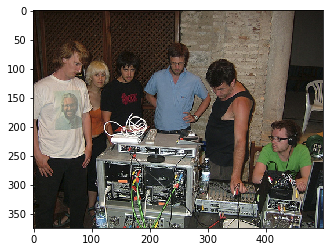

>Generated caption: 
man in black shirt and black pants is sitting on bench
>Original captions: 
group of people are standing around sound mixing table
group of people looking at sound equipment
people are inspecting sound equipment indoors
people examine equipment
six people standing behind electrical equipment
>BLEU4 score: 0.000


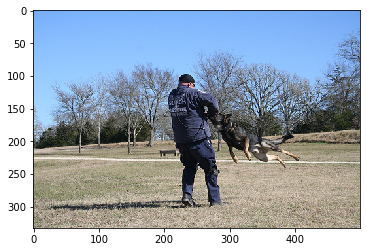

>Generated caption: 
two dogs are running through the grass
>Original captions: 
dog is jumping up at man wearing search and rescue jacket
large black dog is practicing attacking culprit on uniformed man
man in uniform playing with black dog
man in blue with black hat with dog leaping at him in parklike setting
man in blue padded suit training black dog for search and rescue in field
>BLEU4 score: 0.000


In [59]:
for e in worst:
    orig_image = e["orig_image"]
    caption = e["caption"]
    all_caps = e["all_caps"]
    bleu = e["bleu"]

    plt.imshow(np.squeeze(orig_image))
    #plt.title("Sampled Image")
    #plt.figtext(0.5, 0.01, caption, wrap=True, ha='center', fontsize=12)
    #plt.figtext(0.5, -0.05, "BLEU4 score: {:.2f}".format(bleu), wrap=True, ha='center', fontsize=12)
    plt.show()
    print(">Generated caption: ")
    print(caption)
    print(">Original captions: ")
    for c in all_caps:
        print(c)
    print(">BLEU4 score: {:.3f}".format(bleu))


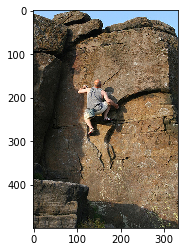

>Generated caption: 
['man climbing rock wall', 'man climbs rock wall', 'man is climbing up rock wall', 'man is climbing rock wall', 'man climbing rock wall in']
>Original captions: 
man dressed in grey climbing large brown rock
man in gray shirt climbs large rock wall
man in shorts climbs rock face
man climbing rock wall
the back of man climbing rock
>BLEU4 score: 1.000


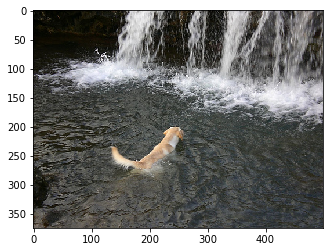

>Generated caption: 
['dog swims through the water', 'dog swims through the water in the water', 'dog swims in the water', 'dog swims through the water in the water', 'dog swims through the water in the water in the background']
>Original captions: 
dog swims towards waterfall
tan and white dog swimming towards waterfall
yellow dog swims towards waterfall
the dog swims through the water toward the waterfall
the dog swims towards waterfall
>BLEU4 score: 1.000


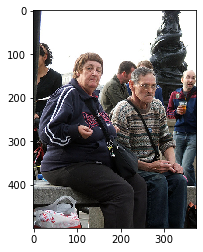

>Generated caption: 
['man and woman sitting on bench', 'man and woman sitting on bench in', 'man and woman sitting on bench in the background', 'man and woman sitting on bench in the background', 'man and woman sitting on bench on']
>Original captions: 
man and woman sitting on bench
an older couple is resting on bench
an older man and woman sitting on cement bench with frowns on their faces
an older woman and an old man sitting down looking unhappy
an overweight woman and man have upset faces as they sit on bench
>BLEU4 score: 1.000


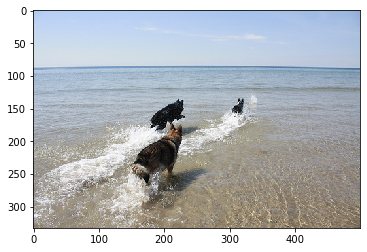

>Generated caption: 
['two dogs are playing in the water on the beach', 'two dogs are playing in the water', 'two dogs play in the water', 'two dogs are playing in the water in the yard', 'two dogs are playing in the water in the background']
>Original captions: 
three dogs are running in the water on the beach
three dogs entering the ocean
three dogs rush to chase ball thrown into the surf
three dogs walking away on the waters edge of the shore
three large dogs are playing in the water at the beach
>BLEU4 score: 0.880


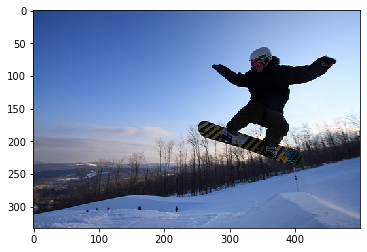

>Generated caption: 
['snowboarder jumps off the snow', 'snowboarder jumps off the hill in the snow in the background', 'snowboarder jumps off the hill in the snow', 'snowboarder jumps off the hill in the snow in the background', 'snowboarder jumps off the snow in the snow']
>Original captions: 
lone snowboarder jumping in the air doing trick
man in black is taking jump on snowboard
person riding snowboard jumps high over the snowy hill
person with yellow and black striped snowboard jumps on the snowy hill
snowboarder jumps off the snow jump
>BLEU4 score: 0.819


In [60]:
results_beam = sorted(results_beam, key=lambda k: k['bleu'], reverse=True) 

top = results_beam[0:5]
worst = results_beam[-5:]

for e in top:
    orig_image = e["orig_image"]
    caption = e["caption"]
    all_caps = e["all_caps"]
    bleu = e["bleu"]

    plt.imshow(np.squeeze(orig_image))
    #plt.title("Sampled Image")
    #plt.figtext(0.5, 0.01, caption, wrap=True, ha='center', fontsize=12)
    #plt.figtext(0.5, -0.05, "BLEU4 score: {:.2f}".format(bleu), wrap=True, ha='center', fontsize=12)
    plt.show()
    print(">Generated caption: ")
    print(caption)
    print(">Original captions: ")
    for c in all_caps:
        print(c)
    print(">BLEU4 score: {:.3f}".format(bleu))


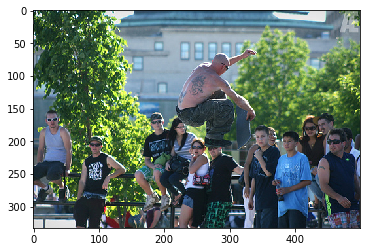

>Generated caption: 
['two men play hockey', 'two men play hockey on the court', 'two men play hockey in the background', 'two men play hockey in the background', 'two men play hockey in the background']
>Original captions: 
man does trick on his skateboard in front of crowd
skateboarder without shirt grabs his board in the air
young man shocks the audience with his skateboard tricks
man with no shirt and tatoos on back airborne with skateboard in hand
the skateboarder performs jump in front of crowd of spectators
>BLEU4 score: 0.000


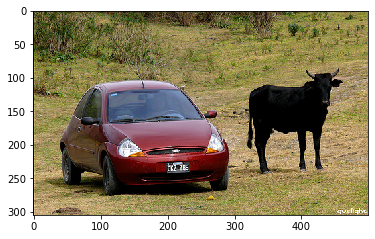

>Generated caption: 
['man and woman are sitting on bench', 'two people are standing in front of some <unk>', 'man and woman are sitting on bench in the background', 'man and woman are sitting on bench in the background', 'man and woman are sitting on bench in']
>Original captions: 
bull stands in field next to red car
red car is parked next to black bull in grassy field
red car parked next to cow in field
large black animal is as large as small red car
there is small red car with black bull standing beside it in the middle of field
>BLEU4 score: 0.000


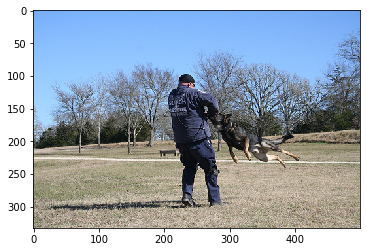

>Generated caption: 
['two dogs are running through the grass', 'two dogs are running through the grass in the background', 'two dogs are running through the grass in the background', 'two dogs are playing in the grass in the background', 'two dogs are playing in the grass']
>Original captions: 
dog is jumping up at man wearing search and rescue jacket
large black dog is practicing attacking culprit on uniformed man
man in uniform playing with black dog
man in blue with black hat with dog leaping at him in parklike setting
man in blue padded suit training black dog for search and rescue in field
>BLEU4 score: 0.000


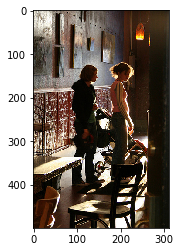

>Generated caption: 
['the skateboarder is performing trick', 'the skateboarder is performing trick in the air', 'the skateboarder is performing trick in the background', 'the skateboarder is performing trick in the background', 'the skateboarder is performing trick in']
>Original captions: 
two ladies next to stroller inside building
two woman stand near stroller in dark building
two women with baby carriage in building next to table and chairs
two women with baby stroller in fancy restaurant
two women with strollers standing next to table and chair
>BLEU4 score: 0.000


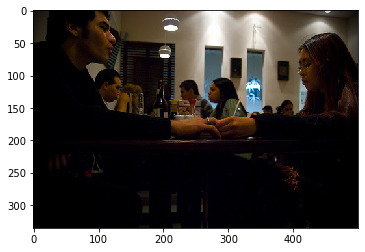

>Generated caption: 
['two people sit on bench', 'man and woman sitting on bench', 'two people sit on bench in front of building', 'two people sitting on bench in front of building', 'two people sit on bench on']
>Original captions: 
couple in restaurant are holding hands
couple holding hands across table
couple is sitting in restaurant holding hands
dimly lit room with several individuals including young man and woman holding hands across table
man and woman are sitting at restaurant table holding hands
>BLEU4 score: 0.000


In [61]:
for e in worst:
    orig_image = e["orig_image"]
    caption = e["caption"]
    all_caps = e["all_caps"]
    bleu = e["bleu"]

    plt.imshow(np.squeeze(orig_image))
    #plt.title("Sampled Image")
    #plt.figtext(0.5, 0.01, caption, wrap=True, ha='center', fontsize=12)
    #plt.figtext(0.5, -0.05, "BLEU4 score: {:.2f}".format(bleu), wrap=True, ha='center', fontsize=12)
    plt.show()
    print(">Generated caption: ")
    print(caption)
    print(">Original captions: ")
    for c in all_caps:
        print(c)
    print(">BLEU4 score: {:.3f}".format(bleu))


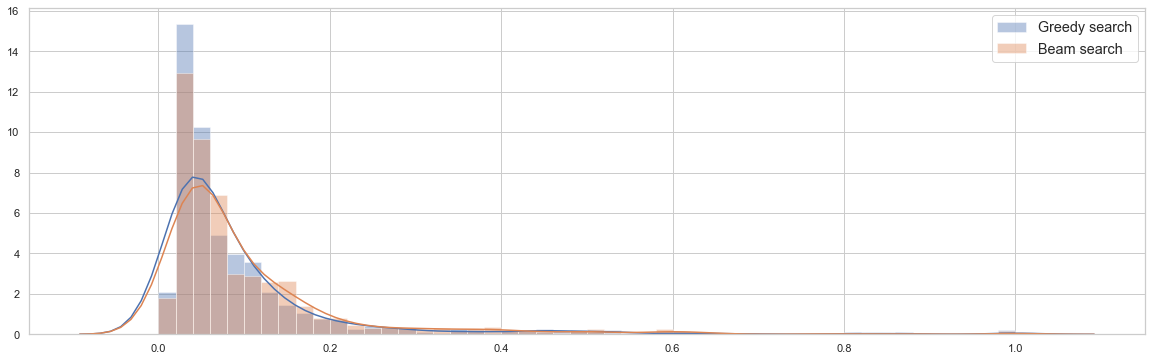

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

greedy_test_bleu = [d['bleu'] for d in results]
beam_test_bleu = [d['bleu'] for d in results_beam]

sns.set(style="whitegrid")
plt.figure(figsize=(20, 6))
sns.distplot(greedy_test_bleu, label="Greedy search")
sns.distplot(beam_test_bleu, label="Beam search")
plt.legend(fontsize="large")

In [63]:
from numpy import asarray
from numpy import savetxt
from datetime import date
today = date.today()
d = today.strftime("%m_%d")

data = asarray([greedy_test_bleu, beam_test_bleu])
savetxt('data/results/greedy_beam_{}.csv'.format(d), data, delimiter=',')

wandb.run.summary["greedy_test_bleu"] = greedy_test_bleu
wandb.run.summary["beam_test_bleu"] = beam_test_bleu

In [ ]:
from numpy import loadtxt
data = loadtxt('data/results/greedy_beam_19_04.csv', delimiter=',')
greedy_test_bleu = data[0]
beam_test_bleu = data[1]
